In [22]:
# ============================================
# 1. IMPORT LIBRARIES
# ============================================
import pandas as pd
import numpy as np
import torch
from sentence_transformers import SentenceTransformer, util
import networkx as nx
from datetime import datetime
import random
import matplotlib.pyplot as plt
from tqdm import tqdm

In [23]:
# ============================================
# 2. LOAD DATA (1000 FAKE + 1000 TRUE)
# ============================================
fake_path = r"C:\Users\gikonyo.njendu\MA461\network-venv\archive\Fake.csv"
true_path = r"C:\Users\gikonyo.njendu\MA461\network-venv\archive\True.csv"

fake_df = pd.read_csv(fake_path).sample(1000, random_state=42)
true_df = pd.read_csv(true_path).sample(1000, random_state=42)

fake_df["label"] = "fake"
true_df["label"] = "true"

df = pd.concat([fake_df, true_df]).reset_index(drop=True)

df["text_full"] = df["title"] + " " + df["text"]

# -------------------------------
# CORRECT DATE PARSING (MM/DD/YYYY)
# -------------------------------
df["date"] = pd.to_datetime(df["date"].astype(str).str.strip(),
                            format="%B %d, %Y",
                            errors="coerce")

# Remove rows where date failed to parse
df = df.dropna(subset=["date"])
df = df.reset_index(drop=True)

In [24]:
# ============================================
# 3. BERT EMBEDDINGS
# ============================================
model = SentenceTransformer("all-MiniLM-L6-v2")

corpus = df["text_full"].tolist()
embeddings = model.encode(corpus, convert_to_tensor=True, show_progress_bar=True)


Batches:   0%|          | 0/47 [00:00<?, ?it/s]

In [35]:
# ============================================
# 4. BUILD GRAPH BASED ON SIMILARITY RULES
#    Conditions:
#    • similarity > 0.5 → edge
#    • weight = (sim / (1-0.5)) - 1
#    • direction: earlier date → later date
#    • if same date: no edge
# ============================================
G = nx.DiGraph()

# Add all nodes
for i in range(len(df)):
    G.add_node(i, label=df.loc[i, "label"], date=df.loc[i, "date"], text=df.loc[i,"text_full"])

# Compute cosine similarity matrix (GPU optimized)
sim_matrix = util.cos_sim(embeddings, embeddings).cpu().numpy()
threshold = 0.6

print("Building edges...")
for i in tqdm(range(len(df))):
    for j in range(len(df)):
        if i == j:
            continue
        
        sim = sim_matrix[i, j]
        if sim > threshold:
            # Direction depends on date
            if df.loc[i,"date"] < df.loc[j,"date"]:
                weight = (sim / 0.5) - 1
                G.add_edge(i, j, weight=weight)


Building edges...


100%|█████████████████████████████████████████████████████████████████████████████| 1497/1497 [00:03<00:00, 480.80it/s]


In [36]:
# ============================================
# INDEPENDENT CASCADE MODEL (FAKE-NODES ONLY)
# ============================================
def independent_cascade(G, seed_set):
    active = set(seed_set)

    # Remove non-fake seeds
    active = {v for v in active if G.nodes[v]["label"] == "fake"}

    newly_active = set(active)

    while newly_active:
        next_active = set()
        for node in newly_active:
            for nbr in G.successors(node):
                if nbr not in active and G.nodes[node]["label"] == "fake":
                    p = G[node][nbr]["weight"]
                    if random.random() < p:
                        next_active.add(nbr)
        newly_active = next_active
        active |= newly_active

    return active


In [37]:
# ============================================
# EXPECTED CASCADE SIZE OF A SEED SET
# ============================================
def estimate_influence(G, S, simulations=30):
    sizes = []
    for _ in range(simulations):
        result = independent_cascade(G, S)
        sizes.append(len(result))
    return np.mean(sizes)


In [38]:
# ============================================
# HILL CLIMBING: TOP-K MOST INFLUENTIAL FAKE POSTS
# ============================================

def hill_climbing(G, k=10):
    S = []
    candidates = [n for n in G.nodes if G.nodes[n]["label"] == "fake"]

    for i in range(k):
        best_node = None
        best_gain = -1
        
        for u in candidates:
            if u in S:
                continue
            gain = estimate_influence(G, S + [u])
            if gain > best_gain:
                best_gain = gain
                best_node = u

        S.append(best_node)

    return S

top10_fake = hill_climbing(G, k=10)
print("Top 10 influential misinformation nodes:", top10_fake)


Top 10 influential misinformation nodes: [429, 253, 421, 258, 309, 226, 201, 114, 194, 211]


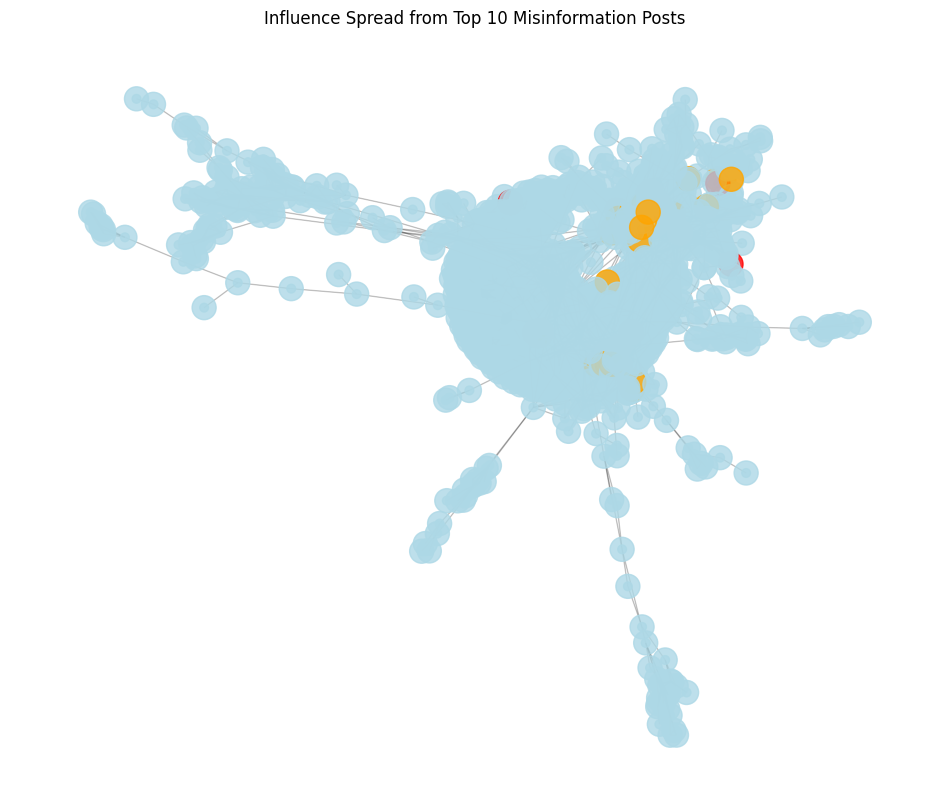

In [44]:
# ============================================
# VISUALIZE INFLUENCE SPREAD FROM TOP SEEDS
# ============================================
activated = independent_cascade(G, top10_fake)

plt.figure(figsize=(12,10))
pos = nx.spring_layout(G, seed=42)

colors = []
for n in G.nodes:
    if n in top10_fake:
        colors.append("red")
    elif n in activated:
        colors.append("orange")
    else:
        colors.append("lightblue")

nx.draw_networkx_nodes(
    G,
    pos,
    node_color=colors,
    alpha=0.8,
    node_size=40         # <<--- SMALLER NODES (default ~300)
)

nx.draw_networkx_edges(
    G,
    pos,
    arrows=False,
    alpha=0.15,
    width=0.3
)

nx.draw_networkx_nodes(G, pos, node_color=colors, alpha=0.8)
nx.draw_networkx_edges(G, pos, arrows=False, alpha=0.2)
plt.title("Influence Spread from Top 10 Misinformation Posts")
plt.axis("off")
plt.show()


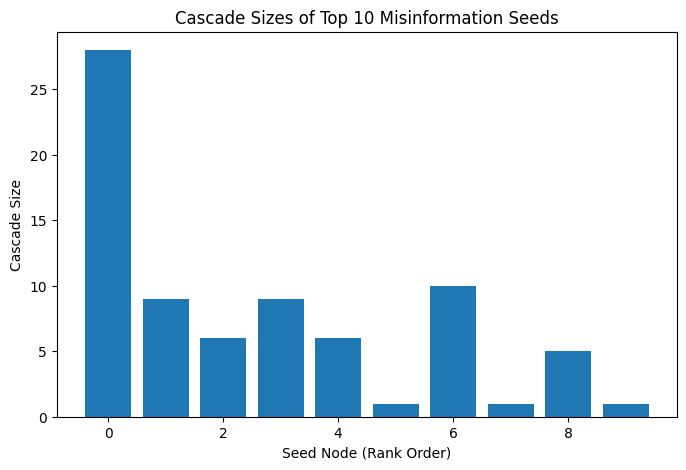

In [40]:
sizes = [len(independent_cascade(G, [node])) for node in top10_fake]

plt.figure(figsize=(8,5))
plt.bar(range(10), sizes)
plt.xlabel("Seed Node (Rank Order)")
plt.ylabel("Cascade Size")
plt.title("Cascade Sizes of Top 10 Misinformation Seeds")
plt.show()

In [41]:
# =========================================================
# PRINT THE MOST INFLUENTIAL MISINFORMATION POST
# =========================================================

top1 = top10_fake[0]   # best seed found by Hill Climbing

print("=====================================")
print(" MOST INFLUENTIAL MISINFORMATION POST")
print("=====================================")
print(f"Node ID: {top1}")
print(f"Date: {df.loc[top1, 'date']}")
print(f"Label: {df.loc[top1, 'label']}")
print()

print("----- TEXT CONTENT -----")
print(df.loc[top1, "text_full"])
print("------------------------")
print()

# Influence spread size
activated = independent_cascade(G, [top1])
print(f"Influence Cascade Size: {len(activated)} nodes")
print()

# Optionally print IDs of nodes influenced
print("Nodes influenced by this post:")
print(list(activated))


 MOST INFLUENTIAL MISINFORMATION POST
Node ID: 429
Date: 2016-12-07 00:00:00
Label: fake

----- TEXT CONTENT -----
 Democrats Introduce Legislation To Probe Russian Voting Hacks, Trump PISSED It s no secret that Donald Trump got a lot of help from the Russian government this election. From the wildfire of fake news spread across the internet to leaks on Hillary Clinton, Russia and its dear leader Vladimir Putin were in the bag for the new president-elect.But there s proof that the Kremlin and its band of thugs may have acted in a more nefarious, intricate way   and Democrats want to expose that.House Democrats, led by ranking member Adam Schiff (California) of the Committee on Intelligence, are set to introduce legislation that calls for a federal probe into whether or not   and to what extent   the Russian government played in the U.S. election via hacking,  to take action on evidence of foreign interference in the 2016 U.S. elections.  California Rep. Eric Swalwell and Maryland Rep. 